In [1]:
from drn_interactions.interactions.loaders import SpontaneousActivityLoader
from drn_interactions.interactions.preprocessors import InteractionsPreprocessor
from drn_interactions.interactions.pairwise import PairwiseCorr, PairwisePartialCorr
from drn_interactions.interactions.popcup import PopulationCoupling
from drn_interactions.interactions.runners import InteractionsRunner
from drn_interactions.interactions.graph_clustering import df_to_graph
from drn_interactions.config import Config, ExperimentInfo
import numpy as np
from drn_interactions.interactions.graph import GraphAttributes, NodeAttributes
import pandas as pd
import seaborn as sns
from drn_interactions.io import load_derived_generic, load_distances
from drn_interactions.transforms.graph import GraphTransformer

In [6]:
neuron_types = load_derived_generic("neuron_types.csv")[
    ["neuron_id", "neuron_type", "session_name"]
]
sessions = neuron_types["session_name"].dropna().unique()
res_corr = []
res_pcorr = []
res_pcup = []
bin_widths = [0.05, 0.1, 0.5, 1, ]

loader_fac = lambda bin_width, shuffle: SpontaneousActivityLoader(
    session_name=sessions[0], bin_width=bin_width, shuffle=shuffle
)
preprocessor_fac = lambda: InteractionsPreprocessor(
    z=True, minmax=False, gaussian_sigma=None
)
corr_fac = lambda: PairwiseCorr()
pcorr_fac = lambda: PairwisePartialCorr()
pcup_fac = lambda: PopulationCoupling()

runner_fac = lambda bin_width, shuffle: InteractionsRunner(
    loader=loader_fac(bin_width, shuffle),
    preprocessor=preprocessor_fac(),
    pcup=pcup_fac(),
    corr=corr_fac(),
    pcorr=pcorr_fac(),
)
for shuffle in (True, False):
    for bin_width in bin_widths:
        runner = runner_fac(bin_width, shuffle)
        res_pcorr.append(runner.run_pcorr_multi(sessions).assign(bin_width=bin_width, shuffle=shuffle))
        res_corr.append(runner.run_corr_multi(sessions).assign(bin_width=bin_width, shuffle=shuffle))
        res_pcup.append(runner.run_pcup_multi(sessions).assign(bin_width=bin_width, shuffle=shuffle))

rsc = (
    pd.concat(res_corr)
    .reset_index(drop=True)
    .rename(columns=dict(corr="value"))
    .assign(metric="rsc")
    .assign(mag=lambda x: np.abs(x["value"]))
)
pcorr = (
    pd.concat(res_pcorr)
    .reset_index(drop=True)
    .rename(columns=dict(pcorr="value"))
    .assign(metric="pcorr")
    .assign(mag=lambda x: np.abs(x["value"]))
)
pcup = (
    pd.concat(res_pcup)
    .reset_index(drop=True)
    .rename(columns=dict(cc="value"))
    .assign(metric="pcup")
    .assign(mag=lambda x: np.abs(x["value"]))
)

In [64]:
graph_attrs = GraphAttributes(inverse_distance=True)

df_distance = load_distances()
sessions = neuron_types["session_name"].dropna().unique()
graph_dfs = []

for bin_width in (0.05, 0.1, 0.5, 1):
    for shuffle_higher in (False, True):
        for session in sessions:
            loader = SpontaneousActivityLoader(
                session_name=session, bin_width=bin_width, block="pre", t_start=0, t_stop=1800
            )
            preprocessor = InteractionsPreprocessor()
            pairwise = PairwiseCorr(rectify=True, shuffle=shuffle_higher)

            spikes = preprocessor(loader())
            df_affinity = (
                pairwise.fit(spikes)
                .get_adjacency_df()
                .dropna(axis=1, thresh=5)
                .dropna(axis=0, thresh=5)
            )
            
            G = df_to_graph(df_affinity, rename_nodes=True)
            graph_stats = graph_attrs.get_graph_attributes(G).assign(
                session=session, shuffle=shuffle_higher, bin_width=bin_width
                )
            graph_dfs.append(graph_stats)

df_graph = pd.concat(graph_dfs).reset_index(drop=True)

In [86]:
# load pairwise, pcorr popcup, ensemble, ensemble_stats, sequenciness, graph stats

rsc = (
    load_derived_generic("corrs/spont - corr.csv")
    .rename(columns=dict(corr="value"))
    .assign(metric="corr")
    .assign(mag=lambda x: np.abs(x["value"]))
    .query("bin_width <= 1")
)
pcorr = (
    load_derived_generic("corrs/spont - pcorr.csv")
    .rename(columns=dict(pcorr="value"))
    .assign(metric="pcorr")
    .assign(mag=lambda x: np.abs(x["value"]))
    .query("bin_width <= 1")
)
# pairwise = pd.concat([rsc, pcorr]).assign(mag=lambda x: np.abs(x["value"]))
pcup = (
    load_derived_generic("corrs/spont - pcup.csv")
    .assign(mag=lambda x: np.abs(x["cc"]))
    .query("bin_width <= 1")
)
ensembles = (
    load_derived_generic("ensembles/spont - ensembles.csv")
    .groupby(["bin_width", "shuffle", "session_name"])["ensemble"]
    .nunique()
    .subtract(1)
    .to_frame("Number of Ensembles")
    .reset_index()
)

seqnmf = load_derived_generic("seqnmf_sequenciness_scores.csv")

<AxesSubplot:xlabel='bin_width', ylabel='mag'>

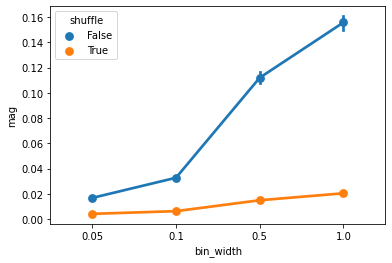

In [7]:
sns.pointplot(x="bin_width", y="mag", hue="shuffle", data=rsc, estimator=np.median)

<AxesSubplot:xlabel='bin_width', ylabel='mag'>

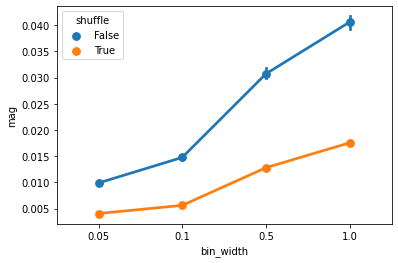

In [8]:
sns.pointplot(x="bin_width", y="mag", hue="shuffle",  data=pcorr, estimator=np.median)

<AxesSubplot:xlabel='bin_width', ylabel='mag'>

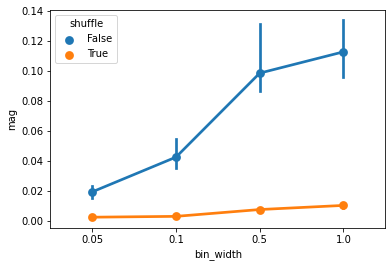

In [9]:
sns.pointplot(x="bin_width", y="mag", hue="shuffle", data=pcup, estimator=np.median)

<AxesSubplot:xlabel='bin_width', ylabel='Number of Ensembles'>

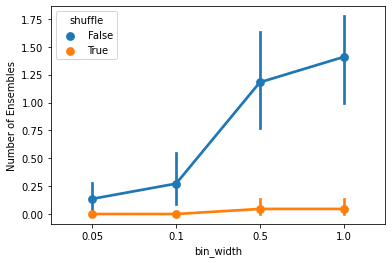

In [75]:
sns.pointplot(
    x="bin_width", 
    y="Number of Ensembles", 
    hue="shuffle", 
    data=ensembles,
    )

<AxesSubplot:xlabel='bin_width', ylabel='avg_clust'>

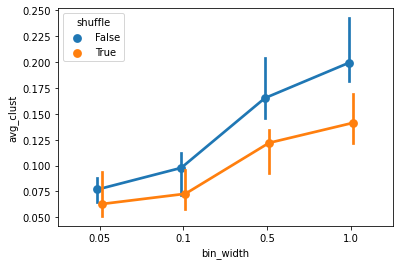

In [71]:
sns.pointplot(x="bin_width", y="avg_clust", hue="shuffle", data=df_graph, ci=95, dodge=True, estimator=np.median)

<AxesSubplot:xlabel='bin_width', ylabel='score'>

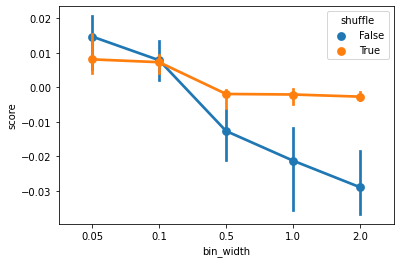

In [90]:
sns.pointplot(x="bin_width", y="score", hue="shuffle", data=seqnmf, estimator=np.median)